## ASSIGNMENT-3

Student IDs: 2022201039, 2023900021

Names: Subhadeep Biswas, Hrithik Sagar

### Instructions
 * Fill in the student ID and name of the team members in the cell above.
 * Code must be written in Python in Jupyter Notebooks. We highly recommend using anaconda distribution or at the minimum, virtual environments for this assignment.
 * You can use the in-built methods and **unless explicitly mentioned**, don't need to code from scratch for this assignment. Make sure your code is modular.
 * All the visualization should be done inside the notebook unless specified otherwise.
 * Plagiarism will lead to a straight zero.
 <!-- * Write a report that briefly describes your approach/algorithm used, your final results and any other findings. -->
 <!-- * Add any report, graphs, plots and other results files in the results folder. -->
 * Submit a zip containing this notebook and results folder on Moodle as <team_name\>.zip. 
 * The deadline is **March 25th, 23:55 IST**. This is a hard deadline, and no submissions will be accepted after this.

### SECTION 1: Coding: Sampling based MPC using MPPI update rule

In Model Predictive Controls, we use a simplified model of the vehicle to predict trajectories for H timesteps into the future. Each timesteps are separated by dt time interval. Using a unicycle kinematics model of the vehicle, write a Model Predictive Controller with the goal reaching cost function and the following constraints:

* Velocity bound constraints
* Angular-velocity bound constraints
* Acceleration bound constraints
* Angular acceleration bound constraints
* Lane boundary constraints
* Static obstacle avoidance constraints

#### Assumptions:
* dt = 0.1
* maximum velocity (vmax) = $20 m/s$
* minimum velocity (vmin) = $0 m/s$
* maximum acceleration (amax) = $5 m/s^2$
* minimum acceleration (amin) = $−5 m/s^2$
* maximum angular-velocity (ωmax) = $0.5 rad/s$
* minimum angular-velocity (ωmin) = $−0.5 rad/s$
* maximum angular acceleration (αmax) = $0.1 rad/s^2$
* minimum angular acceleration (αmin) = $−0.1 rad/s^2$
* the agent and the obstacles are represented as circles of radius 2 meters.
* the road is vertical, and the right road boundary is at $x = 6$, and the left road boundary is at  $x = −6$.

#### Deliverables
* Plot the executed velocity, angular velocity, acceleration and angular acceleration curves.

Ensure the code is well written and runs if the values of certain variables are changed. We can ask you to explain certain snippets of it during the evaluations. All the plots and visualizations need to have proper titles. The code should run properly even if the values of any parameters are changed.

The starter code is given below.

In [1]:
from time import time
import casadi as ca
import numpy as np
from casadi import sin, cos, pi
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import os
import copy
np.set_printoptions(suppress=True)
%matplotlib inline

## [Documentation](https://web.casadi.org/docs/#document-functionhttps://web.casadi.org/docs/)

NLP solvers distributed with CASADI solves a non-linear program in the following form:


\begin{split}\begin{array}{cc}
\begin{array}{c}
\text{minimize:} \\
x
\end{array}
&
f(x,p)
\\
\begin{array}{c}
\text{subject to:}
\end{array}
&
\begin{array}{rcl}
  x_{\textrm{lb}} \le &  x   & \le x_{\textrm{ub}} \\
  g_{\textrm{lb}} \le &g(x,p)& \le g_{\textrm{ub}}
\end{array}
\end{array}\end{split}

Here $x$ is the decision variable and $p$ is a known parameter.

# Helper functions

In [2]:
def DM2Arr(dm):
    return np.array(dm.full())

In [3]:
def draw_circle(x, y, radius):
    th = np.arange(0,2*np.pi,0.01)
    xunit = radius * np.cos(th) + x
    yunit = radius * np.sin(th) + y
    return xunit, yunit  

In [4]:
def draw(agent_list):
    for i in range(len(agent_list)):
        a = agent_list[i]
        x = DM2Arr(a.X)
        u = DM2Arr(a.U)
        g_state = a.state_target #DM2Arr(a.state_target)
        if(a.id == 1):
            col = 'g'
            plt.scatter(g_state[0], g_state[1], marker='x', color='r')
            plt.scatter(x[0,:],x[1,:], marker='.', color='blue', s=1)            
        else:
            col = 'r'
            plt.scatter(x[0,:],x[1,:], marker='.', color=col, s=1)

        x_a, y_a = draw_circle(x[0,0], x[1,0], a.radius) 
        plt.plot(x_a, y_a, col, linewidth=1)


        plt.annotate(str(a.id), xy=(x[0,0]+0.1, x[1,0]+1.2), size=7)
        
        plt.annotate(str(round(u[0,0])), xy=(x[0,0]+0.1, x[1,0]-0.5), size=6)
        

#         plt.plot([(x[0,1]), float(g_state[0])], [x[1,1], float(g_state[1])], linestyle='dotted', c='k')

# MPC Class

In [52]:
class Agent:
    def __init__(self, agent_id, agent_radius, i_state, g_state, obstacles, road_boundaries, N=50):
        self.id = agent_id
        self.radius = agent_radius
        self.i_state = np.array(i_state) # start state
        self.g_state = np.array(g_state) # goal state
        self.obstacles = obstacles
        self.road_boundaries = road_boundaries
        self.state_init =  copy.deepcopy(self.i_state)  # initial state
        self.state_target = copy.deepcopy(self.g_state) # target state
        
        # state symbolic variables
        self.x = ca.SX.sym('x')
        self.y = ca.SX.sym('y')
        self.theta = ca.SX.sym('theta')
        
        self.states = ca.vertcat(
            self.x,
            self.y,
            self.theta
        )
        self.n_states = self.states.numel()

        # control symbolic variables
        self.v = ca.SX.sym('v')
        self.w = ca.SX.sym('w')
        self.controls = ca.vertcat(
            self.v,
            self.w
        )
        self.n_controls = self.controls.numel()
        
        self.N = N # planning horizon
        
        # control bounds
        self.v_ub = 20
        self.v_lb = 0
        self.w_ub = 0.5
        self.w_lb = -0.5
        
        # acceleration and angular acceleration bounds
        self.a_min = -5
        self.a_max = 5
        self.alpha_min = -0.1
        self.alpha_max = 0.1

        # dt
        self.dt = 0.1
        
        # matrix containing all states over all time steps +1 (each column is a state vector)
        self.X = ca.SX.sym('X', self.n_states, self.N + 1)
        # matrix containing all control actions over all time steps (each column is an action vector)
        self.U = ca.SX.sym('U', self.n_controls, self.N)

        # Unicycle model
        self.J = ca.vertcat(
            ca.horzcat(cos(self.theta), 0),
            ca.horzcat(sin(self.theta), 0),
            ca.horzcat( 0, 1)
        )
        # RHS = states + J @ controls * self.dt  # Euler discretization
        self.RHS = self.J @ self.controls
        # maps controls from [v, w].T to [vx, vy, omega].T
        self.f = ca.Function('f', [self.states, self.controls], [self.RHS])
        
    def get_goal_cost(self, X, p_i_state, p_g_state):
        return ca.sumsqr(X[:, 0] - p_i_state) + ca.sumsqr(X[:, -1] - p_g_state)
    
    def next_state_constraints(self, opti, X, U):
        for i in range(self.N):
            opti.subject_to(X[:,i + 1] - X[:,i] == self.f(X[:,i], U[:,i]) * self.dt)

    def control_bound_constraints(self, opti, U):
        opti.subject_to(opti.bounded(self.v_lb, U[0, :], self.v_ub))
        opti.subject_to(opti.bounded(self.w_lb, U[1, :], self.w_ub))
    
    def obstacle_constraints(self, opti, X):
        for obstacle in self.obstacles:
            for i in range(X.shape[1]):
                opti.subject_to(ca.sumsqr(X[:2, i] - obstacle[0]) > (obstacle[1] + self.radius) ** 2)

    def lane_boundary_constraints(self, opti, X):
        opti.subject_to(opti.bounded(self.road_boundaries[0], X[0, :], self.road_boundaries[1]))
    
    # assuming acceleration to be time derivative of the magnitude of the velocity and not the vector velocity
    def acceleration_constraints(self, opti, U):
        opti.subject_to(opti.bounded(self.a_min * self.dt, U[0, 1:] - U[0, :-1], self.a_max * self.dt))
#         opti.subject_to(U[0, 0] == 0) # if the agent starts from rest
    
    def angular_acceleration_constraints(self, opti, U):
        opti.subject_to(opti.bounded(self.alpha_min * self.dt, U[1, 1:] - U[1, :-1], self.alpha_max * self.dt))
#         opti.subject_to(U[1, 0] == 0) # if the agent starts from rest
            
    def pred_controls(self):
        opti = ca.Opti()
        X = opti.variable(self.n_states, self.N + 1)
        U = opti.variable(self.n_controls, self.N)
        p_i_state = opti.parameter(self.n_states)
        p_g_state = opti.parameter(self.n_states)
        
        opti.minimize(self.get_goal_cost(X, p_i_state, p_g_state))
        self.next_state_constraints(opti, X, U)
        self.control_bound_constraints(opti, U)
        self.obstacle_constraints(opti, X)
        self.lane_boundary_constraints(opti, X)
        self.acceleration_constraints(opti, U)
        self.angular_acceleration_constraints(opti, U)
        
        opti.set_value(p_i_state, self.i_state)
        opti.set_value(p_g_state, self.g_state)
        opti.solver('ipopt')
        opti.solve()
        self.X = ca.DM(opti.value(X))
        self.U = ca.DM(opti.value(U))

## Environment

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      550
Number of nonzeros in inequality constraint Jacobian.:      449
Number of nonzeros in Lagrangian Hessian.............:      203

Total number of variables............................:      253
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      150
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:       51
   inequality constraints with lower and upper bounds:      249
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.2049348e+03 3.75e+00 9.61e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

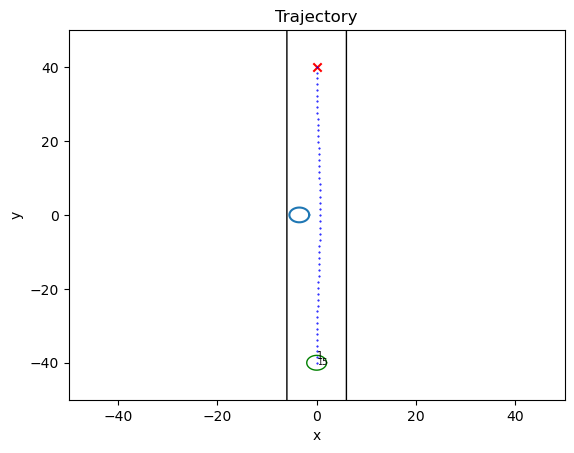

In [53]:
road_boundaries = [-6, 6]
y_lane = np.arange(-1000,1000)
left_lane = road_boundaries[0]*np.ones(y_lane.shape)
right_lane = road_boundaries[1]*np.ones(y_lane.shape)

# obstacles = [([-3.5,0], 4), ([3.5,-20], 4)]
obstacles = [([-3.5,0], 2)]

i_state, g_state = [0, -40, np.deg2rad(90)],[0, 40,np.deg2rad(90)]

a = Agent(1, 2.0, i_state, g_state, obstacles, road_boundaries, 50)
draw_list = [a]
a.pred_controls()
draw(draw_list)
for obs in obstacles:
    obs_x, obs_y = draw_circle(obs[0][0], obs[0][1], obs[1])
    plt.plot(obs_x, obs_y)
plt.plot(left_lane,y_lane, 'k', linewidth=1)
plt.plot(right_lane, y_lane, 'k', linewidth=1)
plt.xlim([-50, 50])
plt.ylim([-50, 50])
plt.title('Trajectory')
plt.xlabel('x'); plt.ylabel('y')
plt.show()

## Show the velocity, angular-velocity, acceleration and angular-acceleration plots

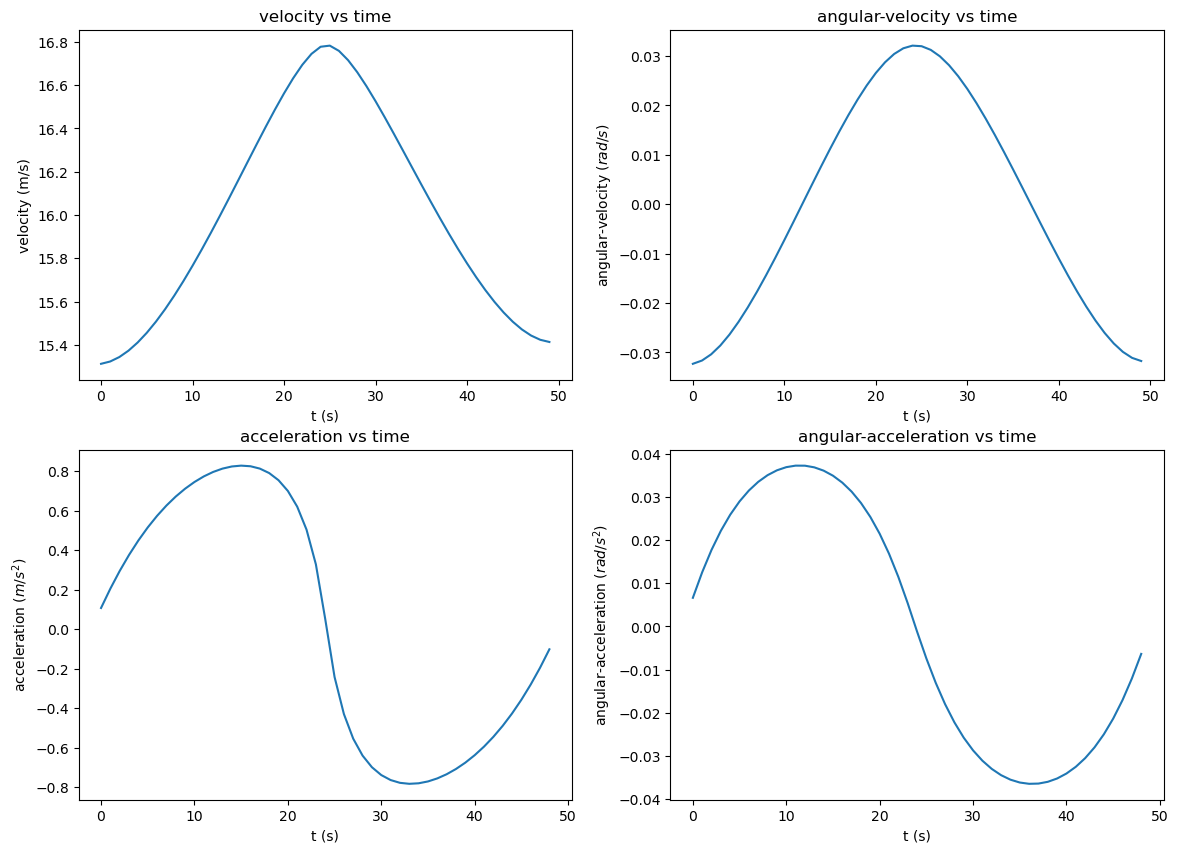

In [54]:
velocity = DM2Arr(a.U[0,:])[0]
angular_velocity = DM2Arr(a.U[1,:])[0]
acceleration = (velocity[1:] - velocity[:-1]) / a.dt
angular_acceleration = (angular_velocity[1:] - angular_velocity[:-1]) / a.dt

fig = plt.figure(figsize = (14, 10))
ax = fig.add_subplot(221)
ax.plot(range(len(velocity)), velocity)
ax.set(title = 'velocity vs time', xlabel = 't (s)', ylabel = 'velocity (m/s)')
ax = fig.add_subplot(222)
ax.plot(range(len(angular_velocity)), angular_velocity)
ax.set(title = 'angular-velocity vs time', xlabel = 't (s)', ylabel = 'angular-velocity ($rad/s$)')
ax = fig.add_subplot(223)
ax.plot(range(len(acceleration)), acceleration)
ax.set(title = 'acceleration vs time', xlabel = 't (s)', ylabel = 'acceleration $(m/s^{2})$')
ax = fig.add_subplot(224)
ax.plot(range(len(angular_acceleration)), angular_acceleration)
ax.set(title = 'angular-acceleration vs time', xlabel = 't (s)', ylabel = 'angular-acceleration ($rad/s^{2}$)')
plt.show()